## Alloy optimization

We use multi-objective optimization to select the cheapest alloys exhibiting an enhanced *X* property after mixing. 

This is a useful problem for illustrating flexibility in defining an optimization problem in MOSA.

In [1]:
from mosa import Anneal
from numpy import random,arange,asarray
from time import time
%matplotlib inline

The pure, fictitious elements have symbols in the **A**...**Z** range. The *X* property and the cost associated with the pure elements was generated by the *generate_data* function below.

In [2]:
def generate_data():
    random.seed(0)
    component=asarray(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
    x0=0.5
    x1=12.6
    k=arange(component.shape[0])+1
    x=x0*k+x1+random.uniform(0.0,5.0,component.shape[0])
    cost=random.uniform(5.0,500.0,component.shape[0])
    
    return component,x,cost

Component,X,Cost=generate_data()

### Translating the alloy optimization problem into Python code

A Python function *fobj* implements the problem. A solution is taken as its only argument. The solution is 
a Python dictionary with the same two keys as the population. In the alloy optimization problem, the first 
element in the "Component" key is the matrix element, while the second is the alloying element. "Concentration" gives the 
relative amount of the alloying element in the alloy. *fobj* returns the values of the two objectives for the current trial solution.

Notice that both the *X* property and the cost of the alloy results from a simple mixing rule considering the *X* property and the cost of the pure elements. 

Also, maximizing *X* is equivalent to minimizing -*X*, that is why -*x* is returned by *fobj*.

In [3]:
def fobj(solution):
    x1=float(X[Component==solution["Component"][0]])
    cost1=float(Cost[Component==solution["Component"][0]])
    x2=float(X[Component==solution["Component"][1]])
    cost2=float(Cost[Component==solution["Component"][1]])
    conc=solution["Concentration"]
    x=x1*(1.0-conc)+x2*conc
    cost=cost1*(1.0-conc)+cost2*conc
        
    return -x,cost

### Initialization

An *Anneal* object is created. Then attributes of the *opt* object are set to control how the optimization process will take place.

In [4]:
opt=Anneal()

--------------------------------------------------
    MULTI-OBJECTIVE SIMULATED ANNEALING (MOSA)    
--------------------------------------------------
         Developed by Prof. Roberto Gomes         
   Universidade Federal do ABC (UFABC), Brazil    




In [5]:
opt.population={"Component":Component.tolist(),"Concentration":(0.0,0.1)}
opt.initial_temperature=1.0
opt.number_of_temperatures=100
opt.number_of_iterations=200
opt.objective_weights=[(X.max()-X.min()),(Cost.max()-Cost.min())]
opt.archive_size=1000
opt.maximum_archive_rejections=1000
opt.number_of_solution_elements={"Component":2,"Concentration":1}
opt.solution_key_selection_weights={"Component":1.0,"Concentration":4.0}
opt.no_repeated_elements={"Component":True}
opt.exchange_probability={"Component":1.0,"Concentration":1.0}
opt.mc_step_size={"Concentration":0.05}

IMPORTANT: Restarting from previous runs is disabled.

In [6]:
opt.restart=False

### Run 1

The optimization process actually occurs when the *evolve* method is called with *fobj* as argument.

In [7]:
opt.archive_file="archive1.json"
start=time()
opt.evolve(fobj)
end=time()
print("   Elapsed time: %f s" % (end-start))
archive1=opt.copyx()

--- BEGIN: Evolving a solution ---

Initializing an empty archive...
Done!
------
Keys in the population/solution dictionaries:
    ['Component']:
        Number of elements in the solution: 2
        Discrete sampling space
        Number of elements in the population: 26
        Elements cannot be repeated in the solution: True
        Selection weight of this key: 1.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from solution: 0.000000
        Solution sorted after change: False
        Maximum step size to select an element in the population, using a triangular distribution: 13
    ['Concentration']:
        Number of elements in the solution: 1
        Continuous sampling space
        Boundaries: (0.0,0.1)
        Selection weight of this key: 4.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deleti

    Number of accepted moves: 105.
    Fraction of accepted moves: 0.525000.
    Number of archive updates: 38.
    Fraction of archive updates in accepted moves: 0.361905.
------
TEMPERATURE: 0.018248
    Number of accepted moves: 124.
    Fraction of accepted moves: 0.620000.
    Number of archive updates: 67.
    Fraction of archive updates in accepted moves: 0.540323.
------
TEMPERATURE: 0.016423
    Number of accepted moves: 100.
    Fraction of accepted moves: 0.500000.
    Number of archive updates: 20.
    Fraction of archive updates in accepted moves: 0.200000.
------
TEMPERATURE: 0.014781
    Number of accepted moves: 64.
    Fraction of accepted moves: 0.320000.
    Number of archive updates: 6.
    Fraction of archive updates in accepted moves: 0.093750.
------
TEMPERATURE: 0.013303
    Number of accepted moves: 94.
    Fraction of accepted moves: 0.470000.
    Number of archive updates: 54.
    Fraction of archive updates in accepted moves: 0.574468.
------
TEMPERATURE: 0.

### Output 1

Below we print the content of the first solution archive, we also print some basic statistics, and then plot *X* vs. *Cost*.

In [8]:
opt.printx()

===
Solutions:
1) {'Component': ['Z', 'U'], 'Concentration': 0.06872612118425768}
2) {'Component': ['R', 'U'], 'Concentration': 0.06872612118425768}
3) {'Component': ['R', 'U'], 'Concentration': 0.08211921681605015}
4) {'Component': ['R', 'U'], 'Concentration': 0.05538191609902671}
5) {'Component': ['R', 'U'], 'Concentration': 0.043905657954019475}
6) {'Component': ['R', 'U'], 'Concentration': 0.0358932411825468}
7) {'Component': ['R', 'U'], 'Concentration': 0.08844297607927629}
8) {'Component': ['R', 'U'], 'Concentration': 0.09145186967519858}
9) {'Component': ['R', 'U'], 'Concentration': 0.09172282375210139}
10) {'Component': ['R', 'U'], 'Concentration': 0.0857894330555152}
11) {'Component': ['R', 'U'], 'Concentration': 0.03384744633424344}
12) {'Component': ['R', 'U'], 'Concentration': 0.06536323716217754}
13) {'Component': ['R', 'U'], 'Concentration': 0.0588742445760735}
14) {'Component': ['X', 'U'], 'Concentration': 0.052631748439480104}
15) {'Component': ['X', 'U'], 'Concentratio

In [9]:
opt.printstats()

===
Objective function 0: 
    Minimum: -28.799322
    Maximum: -21.919707
    Average: -27.360774
===
Objective function 1: 
    Minimum: 14.314331
    Maximum: 222.125321
    Average: 80.970251


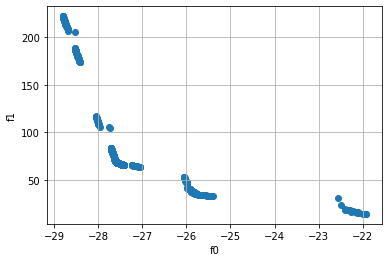

In [10]:
opt.plotfront()

### Run 2

Second optimization run starts from scratch. It means that, by calling the *evolve* method, the previous archive is lost.

In [11]:
opt.archive_file="archive2.json"
start=time()
opt.evolve(fobj)
end=time()
print("   Elapsed time: %f s" % (end-start))
archive2=opt.copyx()

--- BEGIN: Evolving a solution ---

Initializing an empty archive...
Done!
------
Keys in the population/solution dictionaries:
    ['Component']:
        Number of elements in the solution: 2
        Discrete sampling space
        Number of elements in the population: 26
        Elements cannot be repeated in the solution: True
        Selection weight of this key: 1.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from solution: 0.000000
        Solution sorted after change: False
        Maximum step size to select an element in the population, using a triangular distribution: 13
    ['Concentration']:
        Number of elements in the solution: 1
        Continuous sampling space
        Boundaries: (0.0,0.1)
        Selection weight of this key: 4.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deleti

------
TEMPERATURE: 0.022528
    Number of accepted moves: 120.
    Fraction of accepted moves: 0.600000.
    Number of archive updates: 52.
    Fraction of archive updates in accepted moves: 0.433333.
------
TEMPERATURE: 0.020276
    Number of accepted moves: 91.
    Fraction of accepted moves: 0.455000.
    Number of archive updates: 3.
    Fraction of archive updates in accepted moves: 0.032967.
------
TEMPERATURE: 0.018248
    Number of accepted moves: 108.
    Fraction of accepted moves: 0.540000.
    Number of archive updates: 7.
    Fraction of archive updates in accepted moves: 0.064815.
------
TEMPERATURE: 0.016423
    Number of accepted moves: 108.
    Fraction of accepted moves: 0.540000.
    Number of archive updates: 39.
    Fraction of archive updates in accepted moves: 0.361111.
------
TEMPERATURE: 0.014781
    Number of accepted moves: 93.
    Fraction of accepted moves: 0.465000.
    Number of archive updates: 13.
    Fraction of archive updates in accepted moves: 0.13

### Output 2

Below we print the content of the second solution archive, we also print some basic statistics, and then plot *X* vs. *Cost*.

In [12]:
opt.printx()

===
Solutions:
1) {'Component': ['U', 'V'], 'Concentration': 0.04203430867942645}
2) {'Component': ['U', 'V'], 'Concentration': 0.07567161766661158}
3) {'Component': ['U', 'V'], 'Concentration': 0.095271651746426}
4) {'Component': ['U', 'V'], 'Concentration': 0.06336845510778734}
5) {'Component': ['I', 'V'], 'Concentration': 0.06336845510778734}
6) {'Component': ['I', 'V'], 'Concentration': 0.0878461460209252}
7) {'Component': ['I', 'V'], 'Concentration': 0.08004309313799104}
8) {'Component': ['X', 'P'], 'Concentration': 0.0003560784666215913}
9) {'Component': ['X', 'Y'], 'Concentration': 0.0004890362513965824}
10) {'Component': ['R', 'V'], 'Concentration': 0.052557517005791025}
11) {'Component': ['R', 'V'], 'Concentration': 0.09750950140413134}
12) {'Component': ['V', 'U'], 'Concentration': 0.023951396352530532}
13) {'Component': ['V', 'U'], 'Concentration': 0.0884238378176453}
14) {'Component': ['V', 'U'], 'Concentration': 0.08686181290770556}
15) {'Component': ['U', 'X'], 'Concentra

In [13]:
opt.printstats()

===
Objective function 0: 
    Minimum: -28.797936
    Maximum: -21.918294
    Average: -26.368966
===
Objective function 1: 
    Minimum: 14.301817
    Maximum: 222.360238
    Average: 55.681747


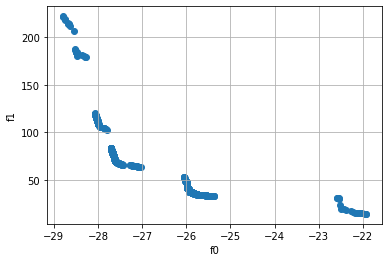

In [14]:
opt.plotfront()

### Run 3

Third optimization run also starts from scratch.

In [15]:
opt.archive_file="archive3.json"
start=time()
opt.evolve(fobj)
end=time()
print("   Elapsed time: %f s" % (end-start))
archive3=opt.copyx()

--- BEGIN: Evolving a solution ---

Initializing an empty archive...
Done!
------
Keys in the population/solution dictionaries:
    ['Component']:
        Number of elements in the solution: 2
        Discrete sampling space
        Number of elements in the population: 26
        Elements cannot be repeated in the solution: True
        Selection weight of this key: 1.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from solution: 0.000000
        Solution sorted after change: False
        Maximum step size to select an element in the population, using a triangular distribution: 13
    ['Concentration']:
        Number of elements in the solution: 1
        Continuous sampling space
        Boundaries: (0.0,0.1)
        Selection weight of this key: 4.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deleti

------
TEMPERATURE: 0.022528
    Number of accepted moves: 103.
    Fraction of accepted moves: 0.515000.
    Number of archive updates: 10.
    Fraction of archive updates in accepted moves: 0.097087.
------
TEMPERATURE: 0.020276
    Number of accepted moves: 86.
    Fraction of accepted moves: 0.430000.
    Number of archive updates: 8.
    Fraction of archive updates in accepted moves: 0.093023.
------
TEMPERATURE: 0.018248
    Number of accepted moves: 115.
    Fraction of accepted moves: 0.575000.
    Number of archive updates: 72.
    Fraction of archive updates in accepted moves: 0.626087.
------
TEMPERATURE: 0.016423
    Number of accepted moves: 114.
    Fraction of accepted moves: 0.570000.
    Number of archive updates: 33.
    Fraction of archive updates in accepted moves: 0.289474.
------
TEMPERATURE: 0.014781
    Number of accepted moves: 106.
    Fraction of accepted moves: 0.530000.
    Number of archive updates: 1.
    Fraction of archive updates in accepted moves: 0.0

### Output 3

Below we print the content of the third solution archive, we also print some basic statistics, and then plot *X* vs. *Cost*.

In [16]:
opt.printx()

===
Solutions:
1) {'Component': ['X', 'V'], 'Concentration': 0.0760606159721029}
2) {'Component': ['X', 'V'], 'Concentration': 0.0629022416907657}
3) {'Component': ['X', 'V'], 'Concentration': 0.004181258203460922}
4) {'Component': ['X', 'V'], 'Concentration': 0.039220654964471635}
5) {'Component': ['X', 'V'], 'Concentration': 0.07544633147162498}
6) {'Component': ['X', 'U'], 'Concentration': 0.05418432415655462}
7) {'Component': ['X', 'U'], 'Concentration': 0.05741992962390533}
8) {'Component': ['X', 'U'], 'Concentration': 0.017308838480335688}
9) {'Component': ['X', 'U'], 'Concentration': 0.057842014572699114}
10) {'Component': ['Z', 'E'], 'Concentration': 0.006512098748993295}
11) {'Component': ['Z', 'E'], 'Concentration': 0.02151100303213821}
12) {'Component': ['Z', 'E'], 'Concentration': 0.00044701417238481034}
13) {'Component': ['U', 'V'], 'Concentration': 0.05132700987934082}
14) {'Component': ['U', 'V'], 'Concentration': 0.08414001940619317}
15) {'Component': ['U', 'V'], 'Conce

In [17]:
opt.printstats()

===
Objective function 0: 
    Minimum: -28.798967
    Maximum: -21.920026
    Average: -27.221406
===
Objective function 1: 
    Minimum: 14.327681
    Maximum: 222.121122
    Average: 81.218938


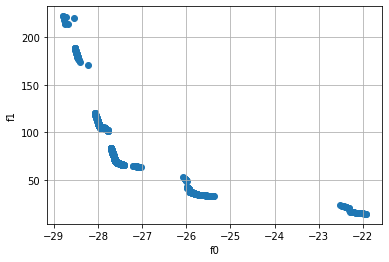

In [18]:
opt.plotfront()

### Merges the three solution archives and removes the dominated solutions from the resulting archive

Next, we merge the three solution archives and eliminate from the resulting archive the dominated solutions, printing only the non-dominated solutions and some basic statistics, and plotting again *X* vs. *Cost*. Merging archives from different runs, as you can see, provides a simple manner of performing parallel runs.

In [19]:
start=time()
merged=opt.mergex([archive1,archive2,archive3])
pruned=opt.prunedominated(xset=merged,delduplicated=True)
opt.savex(xset=pruned,archivefile="merged_archive.json")
opt.printx(pruned)
end=time()
print("   Elapsed time: %f s" % (end-start))

===
Solutions:
1) {'Component': ['Z', 'U'], 'Concentration': 0.06872612118425768}
2) {'Component': ['R', 'U'], 'Concentration': 0.08844297607927629}
3) {'Component': ['R', 'U'], 'Concentration': 0.09145186967519858}
4) {'Component': ['R', 'U'], 'Concentration': 0.09172282375210139}
5) {'Component': ['R', 'U'], 'Concentration': 0.0857894330555152}
6) {'Component': ['X', 'U'], 'Concentration': 0.052631748439480104}
7) {'Component': ['X', 'U'], 'Concentration': 0.05890769232734926}
8) {'Component': ['X', 'U'], 'Concentration': 0.03987715725380145}
9) {'Component': ['X', 'U'], 'Concentration': 0.07625987818431747}
10) {'Component': ['X', 'U'], 'Concentration': 0.06170983552228563}
11) {'Component': ['X', 'U'], 'Concentration': 0.02318609719286916}
12) {'Component': ['X', 'U'], 'Concentration': 0.0015918862156528817}
13) {'Component': ['X', 'U'], 'Concentration': 0.05922628369137377}
14) {'Component': ['X', 'U'], 'Concentration': 0.0473037626926117}
15) {'Component': ['X', 'U'], 'Concentrat

563) [-27.602781956989023, 69.5278269049482]
564) [-27.611504912042854, 70.41309735117109]
565) [-27.043976092906966, 63.51973862631322]
566) [-27.23322232914756, 65.33696140495205]
567) [-27.120671193126924, 64.25619756942534]
568) [-27.58385436313003, 68.59699091853209]
569) [-27.51856892870503, 67.3855741121879]
570) [-27.523710263295634, 67.48097516427478]
571) [-27.53604023390785, 67.70976637555995]
572) [-27.56071555554111, 68.16763419235167]
573) [-27.452926644367945, 66.16753570663639]
574) [-27.49462502086199, 66.94127818881566]
575) [-27.43106108027124, 65.76180490220435]
576) [-27.534443634572167, 67.68014036042685]
577) [-27.49944839417922, 67.03077924753151]
578) [-27.554900740595272, 68.05973624217013]
579) [-27.687821788548657, 80.53716309283293]
580) [-27.67263037686608, 78.60274204139509]
581) [-27.69892243243544, 81.95068012915462]
582) [-27.697398137060024, 81.7565817053592]
583) [-27.71573762506456, 84.09186774788364]
584) [-27.68933170684801, 80.72943079021621]
585

In [20]:
opt.printstats(pruned)

===
Objective function 0: 
    Minimum: -28.799322
    Maximum: -21.918294
    Average: -26.992519
===
Objective function 1: 
    Minimum: 14.301817
    Maximum: 222.125321
    Average: 71.625293


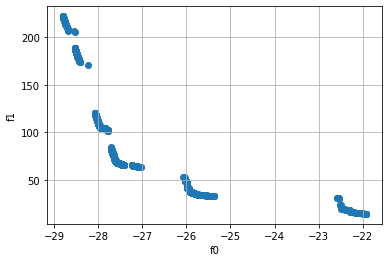

In [21]:
opt.plotfront(pruned)

### Decision making

Many solutions (i.e., candidate alloys) still remain in the archive and it is hard to choose one or two out of them. 

In order to reduce the solution set to something a human being is able to deal with, first, the *trimx* method is 
used to select only the alloys that present a reasonable (according to the users needs) value of the *X* property.

In [22]:
trimmed=opt.trimx(xset=pruned,thresholds=[-25.0,None])
opt.printx(trimmed)

===
Solutions:
1) {'Component': ['Z', 'U'], 'Concentration': 0.06872612118425768}
2) {'Component': ['R', 'U'], 'Concentration': 0.08844297607927629}
3) {'Component': ['R', 'U'], 'Concentration': 0.09145186967519858}
4) {'Component': ['R', 'U'], 'Concentration': 0.09172282375210139}
5) {'Component': ['R', 'U'], 'Concentration': 0.0857894330555152}
6) {'Component': ['X', 'U'], 'Concentration': 0.052631748439480104}
7) {'Component': ['X', 'U'], 'Concentration': 0.05890769232734926}
8) {'Component': ['X', 'U'], 'Concentration': 0.03987715725380145}
9) {'Component': ['X', 'U'], 'Concentration': 0.07625987818431747}
10) {'Component': ['X', 'U'], 'Concentration': 0.06170983552228563}
11) {'Component': ['X', 'U'], 'Concentration': 0.02318609719286916}
12) {'Component': ['X', 'U'], 'Concentration': 0.0015918862156528817}
13) {'Component': ['X', 'U'], 'Concentration': 0.05922628369137377}
14) {'Component': ['X', 'U'], 'Concentration': 0.0473037626926117}
15) {'Component': ['X', 'U'], 'Concentrat

106) [-27.4827484181381, 66.72089953515864]
107) [-27.44693991288546, 66.05644772511597]
108) [-27.46191467257151, 66.33431484378379]
109) [-27.49743835485569, 66.99348156483427]
110) [-27.533588025043148, 67.66426392838271]
111) [-27.56713567806209, 68.28676404710728]
112) [-27.54068753242415, 67.79600024344069]
113) [-27.48542728444035, 66.77060776930128]
114) [-27.539703707908043, 67.77774469281434]
115) [-27.594811047298084, 68.80029984126327]
116) [-27.474257670434593, 66.56334778480198]
117) [-27.442813338523923, 65.97987625740313]
118) [-27.49402022238161, 66.93005573085034]
119) [-27.560145693271316, 68.15706000016002]
120) [-27.59501665002841, 68.8041149434394]
121) [-27.58375851634228, 68.59521241448229]
122) [-27.59490097935001, 68.80196859326126]
123) [-27.44423026425459, 66.00616830337921]
124) [-27.695347306679796, 81.49543616185558]
125) [-27.535471400754485, 67.69921127934188]
126) [-27.533001729662754, 67.65338480835315]
127) [-27.545953517369735, 67.89371426987277]
12

The next step is to reduce a way more the number of solutions. Below, we use the *reducex* method to select 10 alloying candidates with the lowest cost, assuming the cost is the variable that counts the most for the user.

As it can be seen, **R** alloys with about 10\% **I** added as an alloying element are the optimized alloys considering the user needs.

In [23]:
sol1=opt.reducex(xset=trimmed,index=1,nel=10)
opt.printx(sol1)

===
Solutions:
1) {'Component': ['R', 'I'], 'Concentration': 0.09965675306736596}
2) {'Component': ['R', 'I'], 'Concentration': 0.09949334305830773}
3) {'Component': ['R', 'I'], 'Concentration': 0.09941260543655037}
4) {'Component': ['R', 'I'], 'Concentration': 0.09888090604939004}
5) {'Component': ['R', 'I'], 'Concentration': 0.09842167521539676}
6) {'Component': ['R', 'I'], 'Concentration': 0.09699040415411887}
7) {'Component': ['R', 'I'], 'Concentration': 0.09668438512957944}
8) {'Component': ['R', 'I'], 'Concentration': 0.09607456687294716}
9) {'Component': ['R', 'I'], 'Concentration': 0.09583737725979892}
10) {'Component': ['R', 'I'], 'Concentration': 0.09558800665211081}
Values:
1) [-25.379940396020082, 32.7675829526234]
2) [-25.38056867244125, 32.77093459930886]
3) [-25.38087909127265, 32.772590580995136]
4) [-25.38292336132701, 32.78349608488016]
5) [-25.384689005344367, 32.79291521111046]
6) [-25.39019193546033, 32.82227152126657]
7) [-25.39136851294572, 32.82854817258797]
8) 

To reduce the number of candidates even further, we use the *reducex* method again, but now to select 5 alloy candidates with the highest value of the *X* property (or, conversely, the lowest value of -*X*).

In [24]:
sol2=opt.reducex(xset=sol1,index=0,nel=5)
opt.printx(sol2)

===
Solutions:
1) {'Component': ['R', 'I'], 'Concentration': 0.09558800665211081}
2) {'Component': ['R', 'I'], 'Concentration': 0.09583737725979892}
3) {'Component': ['R', 'I'], 'Concentration': 0.09607456687294716}
4) {'Component': ['R', 'I'], 'Concentration': 0.09668438512957944}
5) {'Component': ['R', 'I'], 'Concentration': 0.09699040415411887}
Values:
1) [-25.39558385293643, 32.85103561574518]
2) [-25.39462507645851, 32.84592086068504]
3) [-25.39371313329086, 32.84105594582875]
4) [-25.39136851294572, 32.82854817258797]
5) [-25.39019193546033, 32.82227152126657]
